In [ ]:
!pip install pytorch_lightning
!pip install pytorch_metric_learning
!pip install faiss-cpu
!pip install faiss-gpu
!pip install lightning_lite
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 44.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-man

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
from pathlib import Path
from PIL import Image
from prettytable import PrettyTable
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_metric_learning import losses, miners
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms as T
from lightning_lite.utilities.seed import seed_everything
import csv
import faiss
import faiss.contrib.torch_utils
import numpy as np
import os
import pandas as pd
import pytorch_lightning as pl
import re
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import math
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import CosineSimilarity, DotProductSimilarity
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


import cv2


In [ ]:
#CAN BE MODIFIED

MEAN=[0.485, 0.456, 0.406]; STD=[0.229, 0.224, 0.225]

IM_SIZE = (224, 224)

def input_transform(image_size=IM_SIZE):
    return T.Compose([
        # T.Resize(image_size, interpolation=T.InterpolationMode.BICUBIC),
        T.Resize(image_size,  interpolation=T.InterpolationMode.BILINEAR),

        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])



In [ ]:

DATASET_SF_VAL_ROOT = '/content/drive/MyDrive/Datasets/sf_xs/val/'

path_obj = Path(DATASET_SF_VAL_ROOT)
if not path_obj.exists():
    raise Exception(f'Please make sure the path {DATASET_SF_VAL_ROOT} to SanFrancisco VAL dataset is correct')

if not path_obj.joinpath('ref') or not path_obj.joinpath('query'):
    raise Exception(f'Please make sure the directories query and ref are situated in the directory {DATASET_SF_VAL_ROOT}')

class SFXSValDataset(Dataset):
    def __init__(self, input_transform = None):


        self.input_transform = input_transform

        # reference images names
        self.dbImages = np.load(DATASET_SF_VAL_ROOT+'val_dbImages.npy')
        #print(len(self.dbImages))


        # query images names
        self.qImages = np.load(DATASET_SF_VAL_ROOT+'val_qImages.npy')
        #print(len(self.qImages))

        # ground truth
        self.ground_truth = np.load(DATASET_SF_VAL_ROOT+'val_gt.npy', allow_pickle=True)

        # reference images then query images
        self.images = np.concatenate((self.dbImages, self.qImages))

        self.num_references = len(self.dbImages)

        #print('num reference')
        #print(self.num_references)

        print('num queries')
        self.num_queries = len(self.qImages)
        print(self.num_queries)


    def __getitem__(self, index):
        img = Image.open(DATASET_SF_VAL_ROOT+self.images[index])

        if self.input_transform:
            img = self.input_transform(img)

        return img, index

    def __len__(self):
        return len(self.images)

In [ ]:

DATASET_SF_TEST_ROOT = '/content/drive/MyDrive/Datasets/sf_xs/test/'

path_obj = Path(DATASET_SF_TEST_ROOT)
if not path_obj.exists():
    raise Exception(f'Please make sure the path {DATASET_SF_TEST_ROOT} to SanFrancisco TEST dataset is correct')

if not path_obj.joinpath('ref') or not path_obj.joinpath('query'):
    raise Exception(f'Please make sure the directories query and ref are situated in the directory {DATASET_SF_TEST_ROOT}')

class SFXSTestDataset(Dataset):
    def __init__(self, input_transform = None):


        self.input_transform = input_transform

        # reference images names
        self.dbImages = np.load(DATASET_SF_TEST_ROOT+'test_dbImages.npy')
        #print(len(self.dbImages))



        # query images names
        self.qImages = np.load(DATASET_SF_TEST_ROOT+'test_qImages.npy')
        #print(len(self.qImages))

        # ground truth
        self.ground_truth = np.load(DATASET_SF_TEST_ROOT+'test_gt.npy', allow_pickle=True)

        # reference images then query images
        self.images = np.concatenate((self.dbImages, self.qImages))

        self.num_references = len(self.dbImages)

        #print('num reference')
        #print(self.num_references)

        print('num queries')
        self.num_queries = len(self.qImages)
        print(self.num_queries)


    def __getitem__(self, index):
        img = Image.open(DATASET_SF_TEST_ROOT+self.images[index])

        if self.input_transform:
            img = self.input_transform(img)

        return img, index

    def __len__(self):
        return len(self.images)

In [ ]:

#CANNOT BE MODIFIED
DATASET_TOKIO_TEST_ROOT = '/content/drive/MyDrive/Datasets/tokyo_xs/test/'

path_obj = Path(DATASET_TOKIO_TEST_ROOT)
if not path_obj.exists():
    raise Exception(f'Please make sure the path {DATASET_TOKIO_TEST_ROOT} to TOKIO TEST dataset is correct')

if not path_obj.joinpath('ref') or not path_obj.joinpath('query'):
    raise Exception(f'Please make sure the directories query and ref are situated in the directory {DATASET_TOKIO_TEST_ROOT}')

class TOKIOXSTestDataset(Dataset):
    def __init__(self, input_transform = None):


        self.input_transform = input_transform

        # reference images names
        self.dbImages = np.load(DATASET_TOKIO_TEST_ROOT+'test_dbImages.npy')
        #print(len(self.dbImages))


        # query images names
        self.qImages = np.load(DATASET_TOKIO_TEST_ROOT+'test_qImages.npy')
        #print(len(self.qImages))

        # ground truth
        self.ground_truth = np.load(DATASET_TOKIO_TEST_ROOT+'test_gt.npy', allow_pickle=True)

        # reference images then query images
        self.images = np.concatenate((self.dbImages, self.qImages))

        self.num_references = len(self.dbImages)

        #print('num reference')
        #print(self.num_references)

        print('num queries')
        self.num_queries = len(self.qImages)
        print(self.num_queries)


    def __getitem__(self, index):
        img = Image.open(DATASET_TOKIO_TEST_ROOT+self.images[index])

        if self.input_transform:
            img = self.input_transform(img)

        return img, index

    def __len__(self):
        return len(self.images)

In [ ]:
#CAN BE MODIFIED

def get_val_dataset(dataset_name, input_transform=input_transform()):
    dataset_name = dataset_name.lower()

    if 'sfxsval' in dataset_name:
        ds = SFXSValDataset(input_transform = input_transform)
    elif 'sfxstest' in dataset_name:
        ds = SFXSTestDataset(input_transform = input_transform)
    elif 'tokyotest' in dataset_name:
        ds = TOKIOXSTestDataset(input_transform = input_transform)
    else:
        raise ValueError

    num_references = ds.num_references
    num_queries = ds.num_queries
    ground_truth = ds.ground_truth
    return ds, num_references, num_queries, ground_truth


In [ ]:
#CAN BE MODIFIED
def get_descriptors(model, dataloader, device):
    descriptors = []
    with torch.no_grad():
        for batch in tqdm(dataloader, 'Calculating descritptors...'):
            imgs, labels = batch
            output = model(imgs.to(device)).cpu()
            descriptors.append(output)

    return torch.cat(descriptors)

In [ ]:

def get_validation_recalls(r_list, q_list, k_values, gt, print_results=True, faiss_gpu=False, dataset_name='dataset without name ?', max_display=10):


    embed_size = r_list.shape[1]

    if faiss_gpu:
        res = faiss.StandardGpuResources()
        flat_config = faiss.GpuIndexFlatConfig()
        flat_config.useFloat16 = True
        flat_config.device = 0
        faiss_index = faiss.GpuIndexFlatL2(res, embed_size, flat_config)
    else:
        faiss_index = faiss.IndexFlatL2(embed_size)

    faiss_index.add(r_list)
    distances, predictions = faiss_index.search(q_list, max(k_values))

    correct_at_k = np.zeros(len(k_values))
    correctly_classified = []
    incorrectly_classified = []

    for q_idx, (dists, pred) in enumerate(zip(distances, predictions)):
        correct = False
        correct_preds = []
        correct_dists = []
        for i, n in enumerate(k_values):
          matches = np.in1d(pred[:n], gt[q_idx])
          if np.any(matches):
              correct_at_k[i:] += 1
              correct = True
              correct_preds = pred[:n][matches]
              correct_dists = dists[:n][matches]
              break
        if correct:
            correctly_classified.append((q_idx,  correct_preds, correct_dists))  # Storing query and matched reference
        else:
            incorrectly_classified.append((q_idx, pred[:n], dists[:n]))  # Storing query and matched reference


    correct_at_k = correct_at_k / len(predictions)
    d = {k: v for (k, v) in zip(k_values, correct_at_k)}

    if print_results:
        print('\n')
        table = PrettyTable()
        table.field_names = ['K'] + [str(k) for k in k_values]
        table.add_row(['Recall@K'] + [f'{100 * v:.2f}' for v in correct_at_k])
        print(table.get_string(title=f"Performance on {dataset_name}"))



    return d, predictions, correctly_classified, incorrectly_classified




In [ ]:


# Paths
dataset_path = '/content/drive/MyDrive/Datasets/gsv_xs/'

cities_list = []
df = pd.DataFrame()
cities_list = os.listdir(os.path.join(dataset_path, 'train'))

default_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class GSVCitiesDataset(Dataset):
    def __init__(self,
                 cities,
                 img_per_place=4,
                 min_img_per_place=4,
                 random_sample_from_each_place=True,
                 transform=default_transform,
                 base_path=dataset_path):
        super(GSVCitiesDataset, self).__init__()
        self.base_path = base_path
        self.cities = cities_list

        assert img_per_place <= min_img_per_place, \
            f"img_per_place should be less than {min_img_per_place}"
        self.img_per_place = img_per_place
        self.min_img_per_place = min_img_per_place
        self.random_sample_from_each_place = random_sample_from_each_place
        self.transform = transform

        # Generate the dataframe containing images metadata
        self.dataframe = self._getdataframes()

        # Get all unique place ids
        self.places_ids = pd.unique(self.dataframe.index)
        self.total_nb_images = len(self.dataframe)

    @staticmethod
    def get_img_name(row):
        easting = str(row['easting'])
        northing = str(row['northing'])
        zone = str(row['zone'])
        grid_zone = str(row['grid_zone'])
        #place_id = str(row['place_id'])
        place_id = str(row['place_id_orig']) #MICHELE
        pano_id = row['pano_id']
        year = str(row['year']).zfill(4)
        month = str(row['month']).zfill(2)
        north_degree = str(row['north_degree']).zfill(3)
        lat, lon = str(row['latitude']), str(row['longitude'])
        name = '@' + easting + '@' + northing + '@' + zone + '@' + grid_zone + '@' + lat + '@' + lon + '@' + pano_id + '@@' + \
            north_degree + '@@@@' + year + month + '@' + place_id + '@' + '.jpg'
        return name

    @staticmethod
    def image_loader(path):
        return Image.open(path).convert('RGB')

    def __len__(self):
        '''Denotes the total number of places (not images)'''
        return len(self.places_ids)

    def __getitem__(self, index):
        place_id = self.places_ids[index]

        # Get the place in form of a dataframe (each row corresponds to one image)
        place = self.dataframe.loc[place_id]

        # Sample K images (rows) from this place
        # We can either sort and take the most recent k images
        # or randomly sample them
        if self.random_sample_from_each_place:
            place = place.sample(n=self.img_per_place)
        else:  # Always get the same most recent images
            place = place.sort_values(
                by=['year', 'month', 'latitude'], ascending=False)
            place = place[:self.img_per_place]

        imgs = []
        for i, row in place.iterrows():
            img_name = self.get_img_name(row)
            img_path = os.path.join(self.base_path, 'train', row['city_id'], img_name)

            img = self.image_loader(img_path)

            if self.transform is not None:
                img = self.transform(img)

            imgs.append(img)

        # NOTE: contrary to image classification where __getitem__ returns only one image
        # in GSVCities, we return a place, which is a tensor of K images (K=self.img_per_place)
        # This will return a tensor of shape [K, channels, height, width]. This needs to be taken into account
        # in the DataLoader (which will yield batches of shape [BS, K, channels, height, width])
        return torch.stack(imgs), torch.tensor(place_id).repeat(self.img_per_place)

    def _getdataframes(self):
        #column_names = ['easting', 'northing', 'zone', 'grid_zone', 'latitude', 'longitude', 'pano_id', 'north_degree', 'year', 'month', 'place_id'] #NOTA MICHELE AGGIUNTO PL_ID
        column_names = ['easting', 'northing', 'zone', 'grid_zone', 'latitude', 'longitude', 'pano_id', 'north_degree', 'year', 'month', 'place_id','pl_id','city_id','place_id_orig'] #NOTA MICHELE AGGIUNTO PL_ID e CITY_ID

        list_img_metadata = []

        # Process all records in all folders to obtain a token format of the record and save them in a list


        """
        self.cities=[
        'phoenix',
        'lisbon',
        'london',
        'losangeles',
        'madrid'
            ]
        """
         #RICOMMENTARE
        for city in self.cities: #RICOMMENTARE
        #for city in cities_list: #COMMENTARE
            city_path = os.path.join(self.base_path, 'train', city)
            for filename in os.listdir(city_path):
                # Process the file using your process_file function
                img_metadata = self._process_file_name(filename)
                list_img_metadata.append(img_metadata)
        df = pd.DataFrame(list_img_metadata, columns=column_names)
        res = df[df.groupby('place_id')['place_id'].transform(
            'size') >= self.min_img_per_place]
        return res.set_index('pl_id')

    def _process_file_name(self, file_name):
        # Split the file content using '@' as delimiter
        data_tokens = file_name.split('@')

        # Extract latitude and longitude
        easting = data_tokens[1]
        northing = data_tokens[2]
        zone = data_tokens[3]
        grid_zone = data_tokens[4]
        latitude = data_tokens[5]
        longitude = data_tokens[6]

        # Extract pano ID
        pano_id = data_tokens[7]

        # Extract north degree
        north_degree = data_tokens[9]

        # Extract year and month
        year_month = data_tokens[13]
        year = year_month[:4]
        month = year_month[4:]

        # Extract place ID and city ID
        place_id = data_tokens[14]
        city_id = data_tokens[14].split('_')[1].lower()

        numPlaceID= data_tokens[14].split('_')[0].lower()
        newNumPlaceID = self.cities.index(city_id)*(10**5)+int(numPlaceID)


        # Structure the extracted data as a dictionary
        img_metadata = {
            'easting': easting,
            'northing': northing,
            'zone': zone,
            'grid_zone': grid_zone,
            'latitude': latitude,
            'longitude': longitude,
            'pano_id': pano_id,
            'north_degree': north_degree,
            'year': year,
            'month': month,
            'place_id': newNumPlaceID,
            'pl_id': newNumPlaceID,
            'city_id':city_id,
            'place_id_orig': place_id,

        }
        return img_metadata

##############################################################################################
##############################################################################################
##############################################################################################


IMAGENET_MEAN_STD = {'mean': [0.485, 0.456, 0.406],
                     'std': [0.229, 0.224, 0.225]}

VIT_MEAN_STD = {'mean': [0.5, 0.5, 0.5],
                'std': [0.5, 0.5, 0.5]}

#UNCOMMENT FOR ALL CITY

TRAIN_CITIES = [
    'phoenix',
    'prg', # refers to Prague
    'prs',
    'rome',
    'trt', # refers to Toronto
    'washingtondc',
    'bangkok',
    'barcelona',
    'boston',
    'brussels',
    'buenosaires',
    'chicago',
    'lisbon',
    'london',
    'losangeles',
    'madrid',
    'medellin',
    'melbourne',
    'mexicocity',
    'miami',
    'minneapolis',
    'osaka',
    'osl' # refers to Oslo
]

"""


TRAIN_CITIES = [
    'phoenix',
    'lisbon',
    'london',
    'losangeles',
    'madrid'
]

"""


class GSVCitiesDataModule(pl.LightningDataModule):
    def __init__(self,
                 batch_size=128,
                 img_per_place=4,
                 min_img_per_place=4,
                 shuffle_all=False,
                 image_size=(224, 224),
                 num_workers=8,
                 show_data_stats=True,
                 cities=TRAIN_CITIES,
                 mean_std=IMAGENET_MEAN_STD,
                 batch_sampler=None,
                 random_sample_from_each_place=True,
                 val_set_names = ['sfxsval']
                 ):
        super().__init__()
        self.batch_size = batch_size
        self.img_per_place = img_per_place
        self.min_img_per_place = min_img_per_place
        self.shuffle_all = shuffle_all
        self.image_size = image_size
        self.num_workers = num_workers
        self.batch_sampler = batch_sampler
        self.show_data_stats = show_data_stats
        self.cities = cities
        self.mean_dataset = mean_std['mean']
        self.std_dataset = mean_std['std']
        self.random_sample_from_each_place = random_sample_from_each_place
        self.save_hyperparameters() # save hyperparameter with Pytorch Lightening
        self.val_set_names=val_set_names

        self.train_transform = T.Compose([
            T.Resize(image_size, interpolation=T.InterpolationMode.BILINEAR),
            T.RandAugment(num_ops=3, interpolation=T.InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize(mean=self.mean_dataset, std=self.std_dataset),
        ])

        self.valid_transform = T.Compose([
            T.Resize(image_size, interpolation=T.InterpolationMode.BILINEAR),
            T.ToTensor(),
            T.Normalize(mean=self.mean_dataset, std=self.std_dataset)])

        self.train_loader_config = {
            'batch_size': self.batch_size,
            'num_workers': self.num_workers,
            'drop_last': False,
            'pin_memory': False,
            'shuffle': self.shuffle_all,
            'prefetch_factor': 2,  # Numero di batch pre-caricati per worker
            'persistent_workers': True  # Mantiene i worker attivi tra i batch
        }

        self.valid_loader_config = {
            'batch_size': 256,
            'num_workers': self.num_workers,
            'drop_last': False,
            'pin_memory': True,
            'shuffle': False}



    def setup(self, stage):
        if stage == 'fit':
            # load train dataloader with reload routine
            self.reload()

            self.val_datasets = []
            for valid_set_name in self.val_set_names:
                if 'sfxsval' in valid_set_name.lower():
                    self.val_datasets.append(SFXSValDataset(input_transform=self.valid_transform))
                else:
                    print(f'Validation set {valid_set_name} does not exist or has not been implemented yet')
                    raise NotImplementedError

        if self.show_data_stats:
          self.print_stats()

    def reload(self):
        self.train_dataset = GSVCitiesDataset(
            cities=self.cities,
            img_per_place=self.img_per_place,
            min_img_per_place=self.min_img_per_place,
            random_sample_from_each_place=self.random_sample_from_each_place,
            transform=self.train_transform)

    def train_dataloader(self):
        self.reload()
        return DataLoader(dataset=self.train_dataset, **self.train_loader_config)


    def val_dataloader(self):
      val_dataloaders = []
      for val_dataset in self.val_datasets:
          val_dataloaders.append(DataLoader(
              dataset=val_dataset, **self.valid_loader_config))
      return val_dataloaders


    def print_stats(self):
          print()  # print a new line
          table = PrettyTable()
          table.field_names = ['Data', 'Value']
          table.align['Data'] = "l"
          table.align['Value'] = "l"
          table.header = False
          table.add_row(["# of cities", f"{len(TRAIN_CITIES)}"])
          table.add_row(["# of places", f'{self.train_dataset.__len__()}'])
          table.add_row(["# of images", f'{self.train_dataset.total_nb_images}'])
          print(table.get_string(title="Training Dataset"))
          print()

          table = PrettyTable()
          table.field_names = ['Data', 'Value']
          table.align['Data'] = "l"
          table.align['Value'] = "l"
          table.header = False

          table = PrettyTable()
          table.field_names = ['Data', 'Value']
          table.align['Data'] = "l"
          table.align['Value'] = "l"
          table.header = False
          table.add_row(
              ["Batch size (PxK)", f"{self.batch_size}x{self.img_per_place}"])
          table.add_row(
              ["# of iterations", f"{self.train_dataset.__len__()//self.batch_size}"])
          table.add_row(["Image size", f"{self.image_size}"])
          print(table.get_string(title="Training config"))


##############################################################################################
##############################################################################################
##############################################################################################


class ResNet(nn.Module):
    def __init__(self,
                 ):

        super().__init__()
        weights = 'IMAGENET1K_V1'
        self.model = torchvision.models.resnet18(weights=weights)
        #Avg Pooling is removed to let feature mixer aggregator to work
        self.model.avgpool = None
        #Final FC is not needed
        self.model.fc = None
        #4-th layer is cropped
        self.model.layer4 = None
        #out channels

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        return x

##############################################################################################
##############################################################################################
class FeatureMixerLayer(nn.Module):
    def __init__(self, in_dim, mlp_ratio=1):
        super().__init__()
        self.mix = nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.Linear(in_dim, int(in_dim * mlp_ratio)),
            nn.ReLU(),
            nn.Linear(int(in_dim * mlp_ratio), in_dim),
        )

        for m in self.modules():
            if isinstance(m, (nn.Linear)):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return x + self.mix(x)


class MixVPR(nn.Module):
    def __init__(self,
                 in_channels=256,
                 in_h=14,
                 in_w=14,
                 out_channels=256,
                 mix_depth=5,
                 mlp_ratio=5,
                 out_rows=1,
                 ) -> None:
        super().__init__()

        self.in_h = in_h # height of input feature maps
        self.in_w = in_w # width of input feature maps
        self.in_channels = in_channels # depth of input feature maps

        self.out_channels = out_channels # depth wise projection dimension
        self.out_rows = out_rows # row wise projection dimesion

        self.mix_depth = mix_depth # L the number of stacked FeatureMixers
        self.mlp_ratio = mlp_ratio # ratio of the mid projection layer in the mixer block

        hw = in_h*in_w
        self.mix = nn.Sequential(*[
            FeatureMixerLayer(in_dim=hw, mlp_ratio=mlp_ratio)
            for _ in range(self.mix_depth)
        ])
        self.channel_proj = nn.Linear(in_channels, out_channels)
        self.row_proj = nn.Linear(hw, out_rows)

    def forward(self, x):
        x = x.flatten(2)
        x = self.mix(x)
        x = x.permute(0, 2, 1)
        x = self.channel_proj(x)
        x = x.permute(0, 2, 1)
        x = self.row_proj(x)
        x = torch.nn.functional.normalize(x.flatten(1), p=2, dim=-1)
        return x

class AVGPool(nn.Module):
    """Implementation of Average Pooling layer ."""
    def __init__(self):
        super(AVGPool, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Pooling to a fixed output size (1, 1)

    def forward(self, x):
        x = self.pool(x)  # Perform average pooling
        x = x.flatten(1)  # Flatten the pooled output
        return x.float()

class GeMPool(nn.Module):
    """Implementation of GeM as in https://github.com/filipradenovic/cnnimageretrieval-pytorch
    we add flatten and norm so that we can use it as one aggregation layer.
    """
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        x = F.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(1./self.p)
        x = x.flatten(1)
        return F.normalize(x, p=2, dim=1)

##############################################################################################
##############################################################################################


from pytorch_metric_learning import losses

class VPRModel(pl.LightningModule):

    def __init__(self
                     ,optimizer='adam'
                     ,lossFunction='Multisimilarity'
                     ,miner = 'Multisimilarity'
                     ,reducer=None
                     ,lroptimizer ='MultiStepLR'
                     ):
        super().__init__()
        # Hyperparameters
        self.optimizer=optimizer
        self.lossFunction = lossFunction
        self.miner = miner
        self.reduce = reducer
        self.lroptimizer = lroptimizer

        self.backbone = ResNet()
        self.aggregator = MixVPR( mix_depth=2, mlp_ratio=8, out_rows=7)
        self.gempool = GeMPool
        self.loss_fn = losses.MultiSimilarityLoss(alpha=1.0, beta=50, base=0.0, distance=DotProductSimilarity() )
        self.miner = miners.MultiSimilarityMiner(0.1, distance=CosineSimilarity())

        # Metrics (initialize empty lists)
        self.faiss_gpu = False
        self.validation_step_outputs = []

        # Save hyperparameters
        self.save_hyperparameters()

    def forward(self, x):
        x = self.backbone(x)
        x = self.aggregator(x)
        return x

    def configure_optimizers(self):

        if self.optimizer.lower() == 'sgd':
          optimizer = torch.optim.SGD(self.parameters(),lr=0.03,weight_decay=0.001,momentum=0.9 )
        elif self.optimizer.lower() == 'adam':
          optimizer = torch.optim.Adam(self.parameters(),lr=0.0002)
        elif self.optimizer.lower() == 'adamw':
          optimizer = torch.optim.AdamW(self.parameters(),lr=0.0002,weight_decay=0.001)
        elif self.optimizer.lower() == 'asgd':
          optimizer = torch.optim.ASGD(self.parameters(),lr=0.1)

        if self.lroptimizer == 'MultiStepLR':
          scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[3,6,9,12], gamma=0.3)
        elif self.lroptimizer == 'ReduceLROnPlateau':
          scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=1, verbose=True)
        elif self.lroptimizer == 'CosineAnnealingLR':
          scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=4, eta_min=0.0001)


        return {
           'optimizer': optimizer,
           'lr_scheduler': scheduler, # Changed scheduler to lr_scheduler
           'monitor': 'sfxsR1'
       }

    def loss_function(self, descriptors, labels):
        # Mining (if applicable)
        if self.miner is not None:
            miner_outputs = self.miner(descriptors, labels)
            loss = self.loss_fn(descriptors, labels, miner_outputs)
        else:
            loss = self.loss_fn(descriptors, labels)
        return loss

    def training_step(self, batch, batch_idx):
        places, labels = batch
        BS, N, ch, h, w = places.shape
        # Reshape and forward pass
        images = places.view(BS * N, ch, h, w)
        labels = labels.view(-1)
        descriptors = self(images)
        # Calculate loss
        loss = self.loss_function(descriptors, labels)


        # Log loss and return dictionary
        self.log('train_loss', round(loss.item(),2), prog_bar=True, logger=True)
        self.log('loss', round(loss.item(),2), logger=True)
        return {'loss': loss}

    def on_training_epoch_end(self, training_step_outputs):
        # we empty the batch_acc list for next epoch
          self.batch_acc = []


    # For validation, we will also iterate step by step over the validation set
    # this is the way Pytorch Lghtning is made. All about modularity, folks.
    def validation_step(self, batch, batch_idx, dataloader_idx=None):
        places, _ = batch
        # calculate descriptors
        descriptors = self(places)
        self.validation_step_outputs.append(descriptors.detach().cpu())
        return descriptors.detach().cpu()

    def on_validation_epoch_end(self):
        dm = self.trainer.datamodule
        # The following line is a hack: if we have only one validation set, then
        # we need to put the outputs in a list (Pytorch Lightning does not do it presently)
        if len(dm.val_datasets)==1: # we need to put the outputs in a list
            val_step_outputs = [self.validation_step_outputs]

        for i, (val_set_name, val_dataset) in enumerate(zip(dm.val_set_names, dm.val_datasets)):
            feats = torch.concat(val_step_outputs[i], dim=0)

            num_references = val_dataset.num_references
            num_queries = val_dataset.num_queries
            ground_truth = val_dataset.ground_truth

            # split to ref and queries
            r_list = feats[ : num_references]
            q_list = feats[num_references : ]

            recalls_dict, predictions = get_validation_recalls(r_list=r_list,
                                                q_list=q_list,
                                                k_values=[1, 5, 10, 15, 20, 25],
                                                gt=ground_truth,
                                                print_results=True,
                                                dataset_name=val_set_name,
                                                faiss_gpu=self.faiss_gpu
                                                )
            del r_list, q_list, feats, num_references, ground_truth

            self.log(f'sfxsR1', recalls_dict[1], prog_bar=True, logger=True)
            self.log(f'sfxsR5', recalls_dict[5], prog_bar=True, logger=True)
            self.log(f'sfxsR10', recalls_dict[10], prog_bar=True, logger=True)
            del self.validation_step_outputs
            self.validation_step_outputs = []
        print('\n\n')



In [ ]:
def extract_names_and_distances(query_indices, query_file, reference_file, ground_truth):
    # Carica i file .npy
    query_names = np.load(query_file)
    reference_names = np.load(reference_file)
    ground_truth = np.load(ground_truth, allow_pickle=True)  # Carica la ground truth come array numpy

    # Crea una lista per memorizzare le coppie di nomi, indici e distanze
    query_reference_pairs = []

    # Estrai i nomi delle query e delle reference insieme alle distanze
    for (q_idx, ref_idxs, dists) in query_indices:
        query_name = query_names[q_idx].split('/')[-1]  # Estrai solo il nome del file dalla stringa del percorso
        reference_names_list = [(reference_names[ref_idx].split('/')[-1], ref_idx, dist) for ref_idx, dist in zip(ref_idxs, dists)]  # Estrai i nomi e gli indici delle reference con le distanze
        ground_truth_names = [reference_names[gt_idx].split('/')[-1] for gt_idx in ground_truth[q_idx][:3]]  # Estrai i primi 3 nomi delle immagini della ground truth
        query_reference_pairs.append((query_name, q_idx, reference_names_list, ground_truth_names))

    return query_reference_pairs

def plot_images(query_reference_pairs, query_folder, reference_folder, boolean):
    # Calcola il numero totale di righe necessarie per i subplot
    num_rows = len(query_reference_pairs)

    # Imposta le dimensioni del subplot in base al numero di reference per ogni query
    fig, axes = plt.subplots(num_rows, 9, figsize=(18, 6*num_rows))
    count_sum_idx = 0
    # Visualizza le immagini
    for idx, (query_name, q_idx, reference_names, ground_truth_names) in enumerate(query_reference_pairs):
        query_path = os.path.join(query_folder, query_name)

        # Carica e visualizza la query
        query_image = cv2.imread(query_path)
        query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
        axes[idx+count_sum_idx, 0].imshow(query_image)
        axes[idx+count_sum_idx, 0].set_title(f'Query {q_idx}')
        axes[idx+count_sum_idx, 0].axis('off')

        # Verifica se ci sono più di una reference image associate alla query
        num_references = len(reference_names)

        if num_references == 0:
            continue
        if num_references < 9:
            for i in range(num_references+1, 9):
                axes[idx+count_sum_idx, i].axis('off')

        rf = 1
        count = 0

        if not boolean:
            # Carica e visualizza le immagini della ground truth per le query incorrette
            for gt_name in ground_truth_names:
                gt_path = os.path.join(reference_folder, gt_name)
                gt_image = cv2.imread(gt_path)
                gt_image = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB)
                axes[idx+count_sum_idx, rf].imshow(gt_image)
                axes[idx+count_sum_idx, rf].set_title('GT')
                axes[idx+count_sum_idx, rf].axis('off')

                # Draw rectangle
                rect = plt.Rectangle((0, 0), gt_image.shape[1], gt_image.shape[0], linewidth=10, edgecolor=(0, 0, 1), facecolor='none')
                axes[idx+count_sum_idx, rf].add_patch(rect)
                rf += 1

        # Carica e visualizza le reference
        if boolean:
            reference_names = reference_names[:10]  # Consider only top 10 reference images
        else:
            reference_names = reference_names[:5]  # Consider only top 5 reference images

        for reference_name, ref_idx, dist in reference_names:
            reference_path = os.path.join(reference_folder, reference_name)
            reference_image = cv2.imread(reference_path)
            reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)

            # Disegna un rettangolo verde intorno all'immagine se la predizione è corretta, altrimenti rosso
            color = (0, 1, 0) if boolean else (1, 0, 0)
            if rf>=10:
              rf = 1
              idx = idx +1
              count = count+1
            axes[idx+count_sum_idx, rf].imshow(reference_image)
            axes[idx+count_sum_idx, rf].set_title(f'Dist: {dist:.2f}')
            axes[idx+count_sum_idx, rf].axis('off')

            # Draw rectangle
            rect = plt.Rectangle((0, 0), reference_image.shape[1], reference_image.shape[0], linewidth=10, edgecolor=color, facecolor='none')
            axes[idx+count_sum_idx, rf].add_patch(rect)
            if (rf<=8):
              rf = rf+1
            else:
              break

        count_sum_idx = count_sum_idx + count

    plt.tight_layout()
    plt.show()

In [ ]:
#CAN BE MODIFIED

# define which device you'd like run experiments on (cuda:0 if you only have one gpu)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_model_from_checkpoint(checkpoint_path,device):
  # define which device you'd like run experiments on (cuda:0 if you only have one gpu)
  model = VPRModel()
  checkpoint = torch.load(checkpoint_path)
  state_dict = checkpoint['state_dict']
  model.load_state_dict(state_dict)
  model.eval()
  model = model.to(device)
  return model,device

'''
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = VPRModel(
        )

state_dict = torch.load('/content/drive/My Drive/Colab Notebooks/Latest Version/09 - FREEZED AND UNFREEZED ONLY REGULARIZER AND REDUCES FEATURES/regularized_circle_mixvpr_epoch=2_loss=39.9900016784668_sfxsR1=0.733767032623291_sfxsR5=0.8371074795722961.ckpt') # link to the trained weights
# model.load_state_dict(state_dict)
model.load_state_dict(state_dict['state_dict'])
model.eval()
model = model.to(device)'''

'\ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\n\nmodel = VPRModel(\n        )\n\nstate_dict = torch.load(\'/content/drive/My Drive/Colab Notebooks/Latest Version/09 - FREEZED AND UNFREEZED ONLY REGULARIZER AND REDUCES FEATURES/regularized_circle_mixvpr_epoch=2_loss=39.9900016784668_sfxsR1=0.733767032623291_sfxsR5=0.8371074795722961.ckpt\') # link to the trained weights\n# model.load_state_dict(state_dict)\nmodel.load_state_dict(state_dict[\'state_dict\'])\nmodel.eval()\nmodel = model.to(device)'

Validating checkpoint: /content/drive/My Drive/Colab Notebooks/Latest Version/15 - FINAL TUNING/multisim_mixvpr_epoch=29_loss=0.14000000059604645_sfxsR1=0.8134617805480957_sfxsR5=0.8899036645889282.ckpt
num queries
1000
Evaluating on sfxstest


Calculating descritptors...:   0%|          | 0/705 [00:00<?, ?it/s]



+----------------------------------------------------------+
|                 Performance on sfxstest                  |
+----------+-------+-------+-------+-------+-------+-------+
|    K     |   1   |   5   |   10  |   15  |   20  |   25  |
+----------+-------+-------+-------+-------+-------+-------+
| Recall@K | 54.80 | 68.90 | 72.60 | 74.60 | 76.10 | 77.50 |
+----------+-------+-------+-------+-------+-------+-------+
IMAGES OF sfxstest DATASET


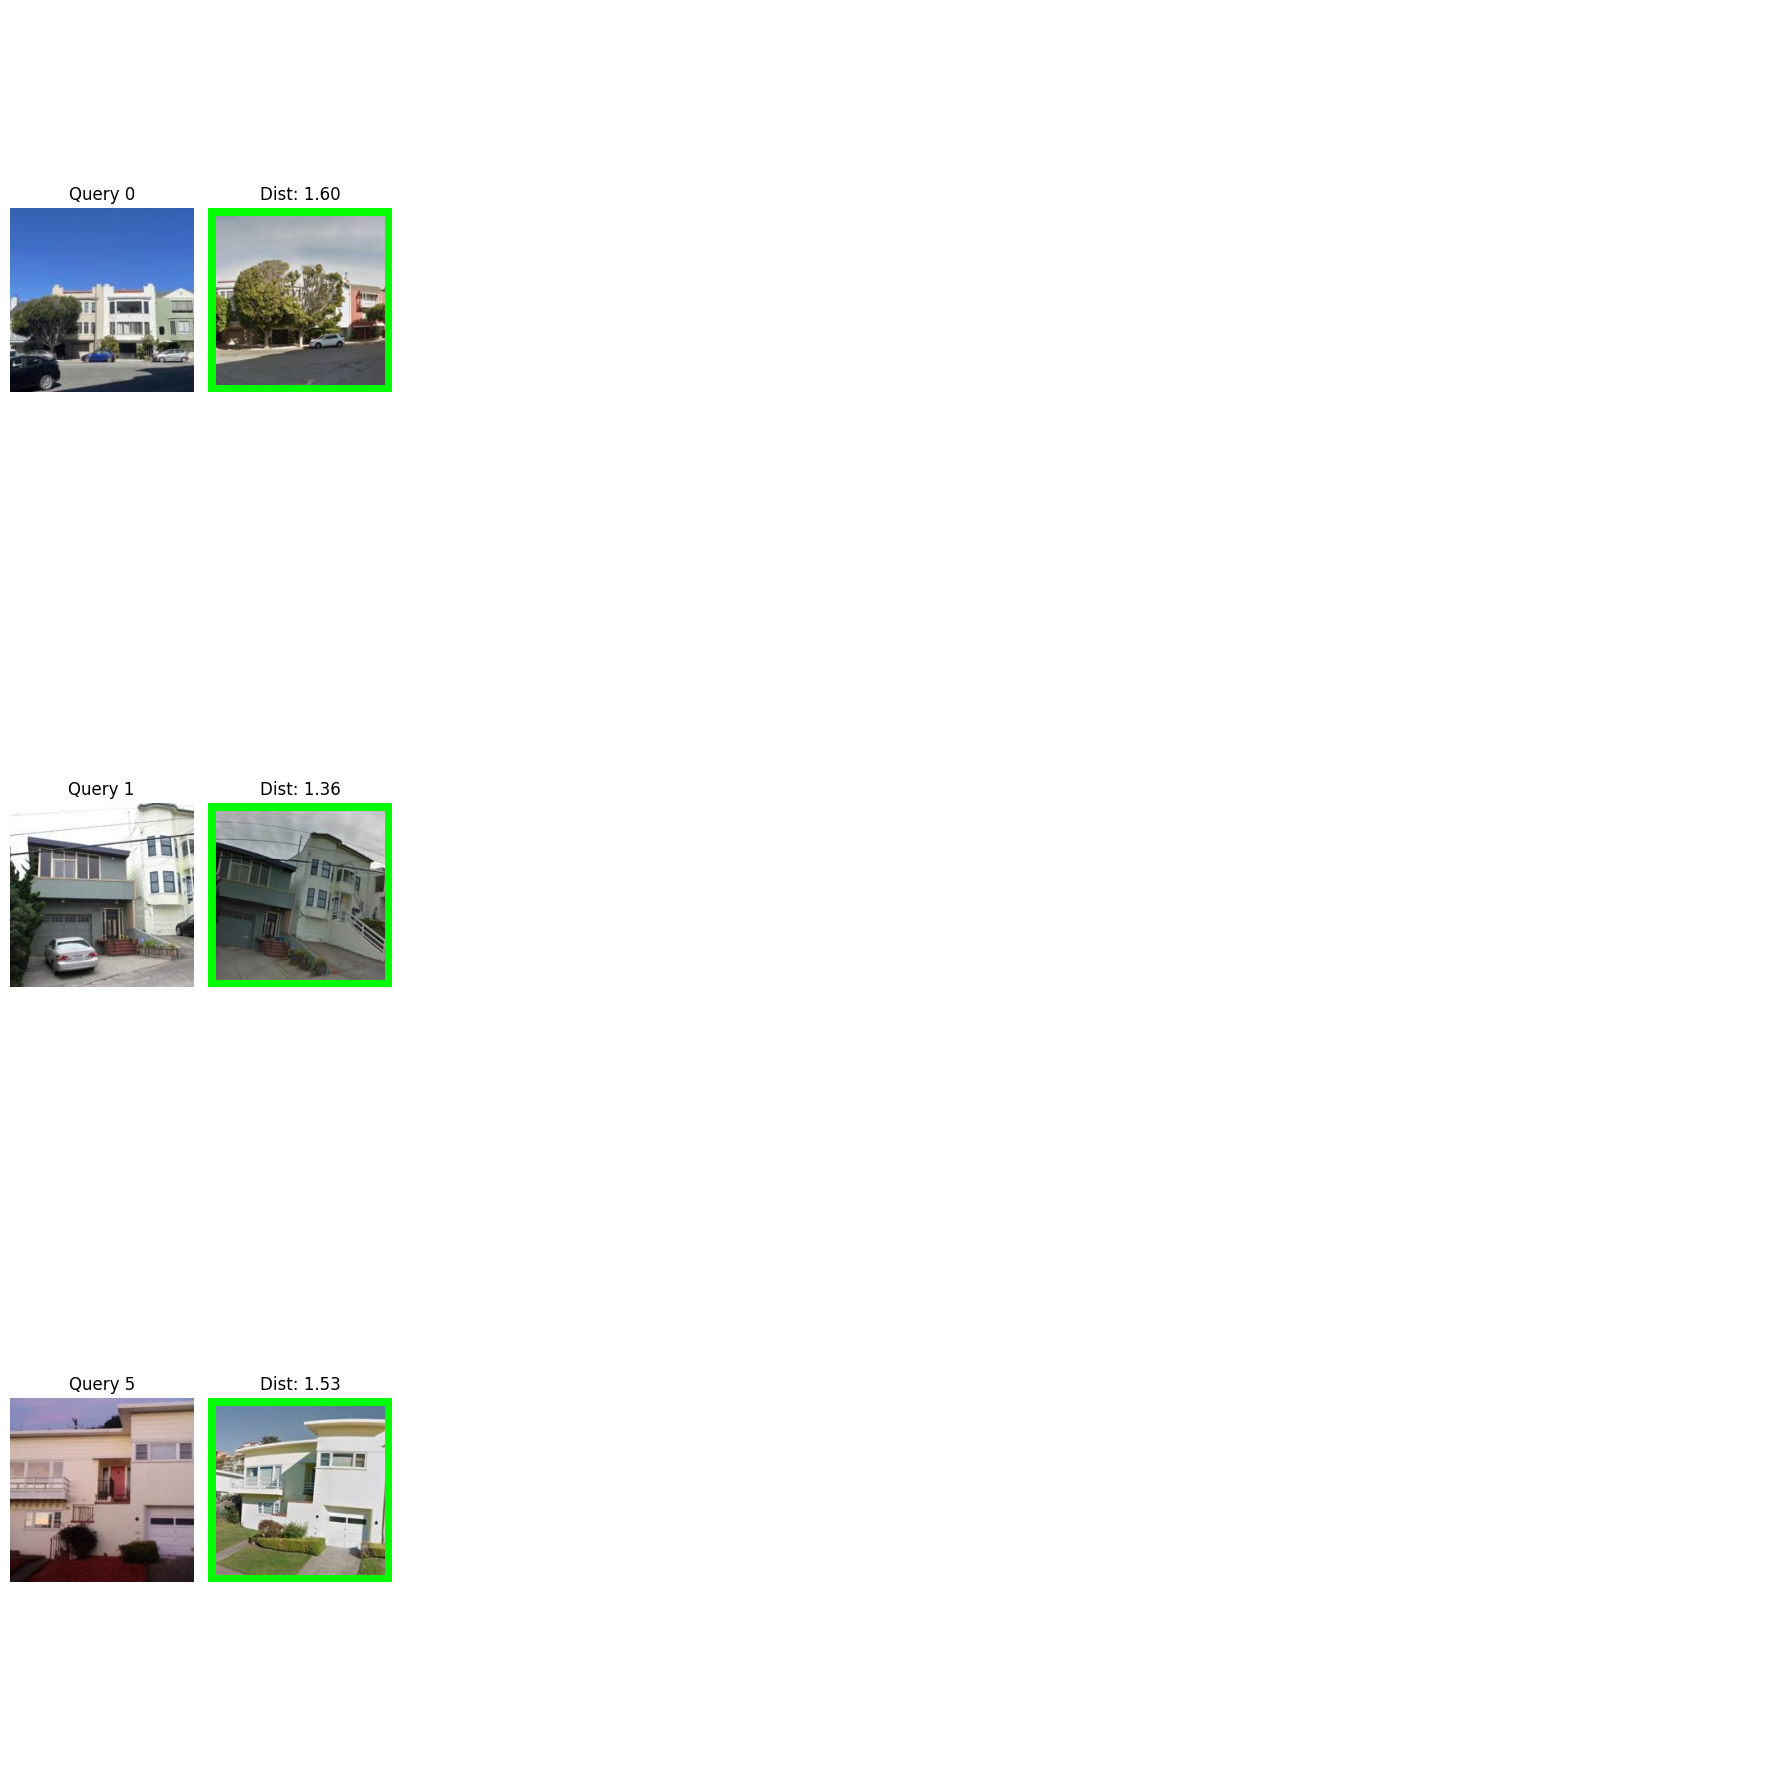

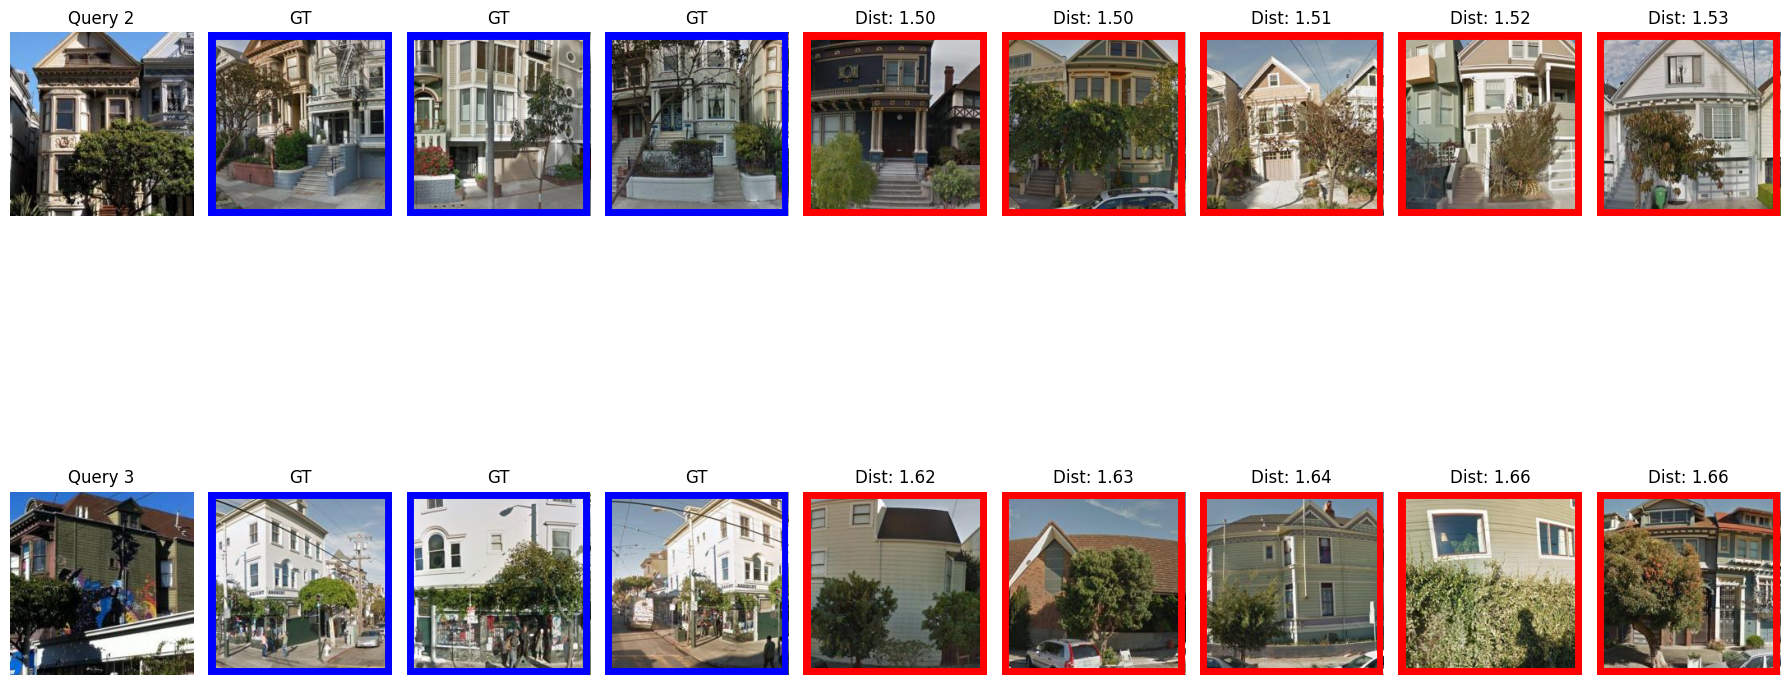

========> DONE!


num queries
7993
Evaluating on sfxsval


Calculating descritptors...:   0%|          | 0/401 [00:00<?, ?it/s]



+----------------------------------------------------------+
|                  Performance on sfxsval                  |
+----------+-------+-------+-------+-------+-------+-------+
|    K     |   1   |   5   |   10  |   15  |   20  |   25  |
+----------+-------+-------+-------+-------+-------+-------+
| Recall@K | 81.35 | 88.99 | 91.37 | 92.48 | 93.49 | 94.07 |
+----------+-------+-------+-------+-------+-------+-------+
IMAGES OF sfxsval DATASET


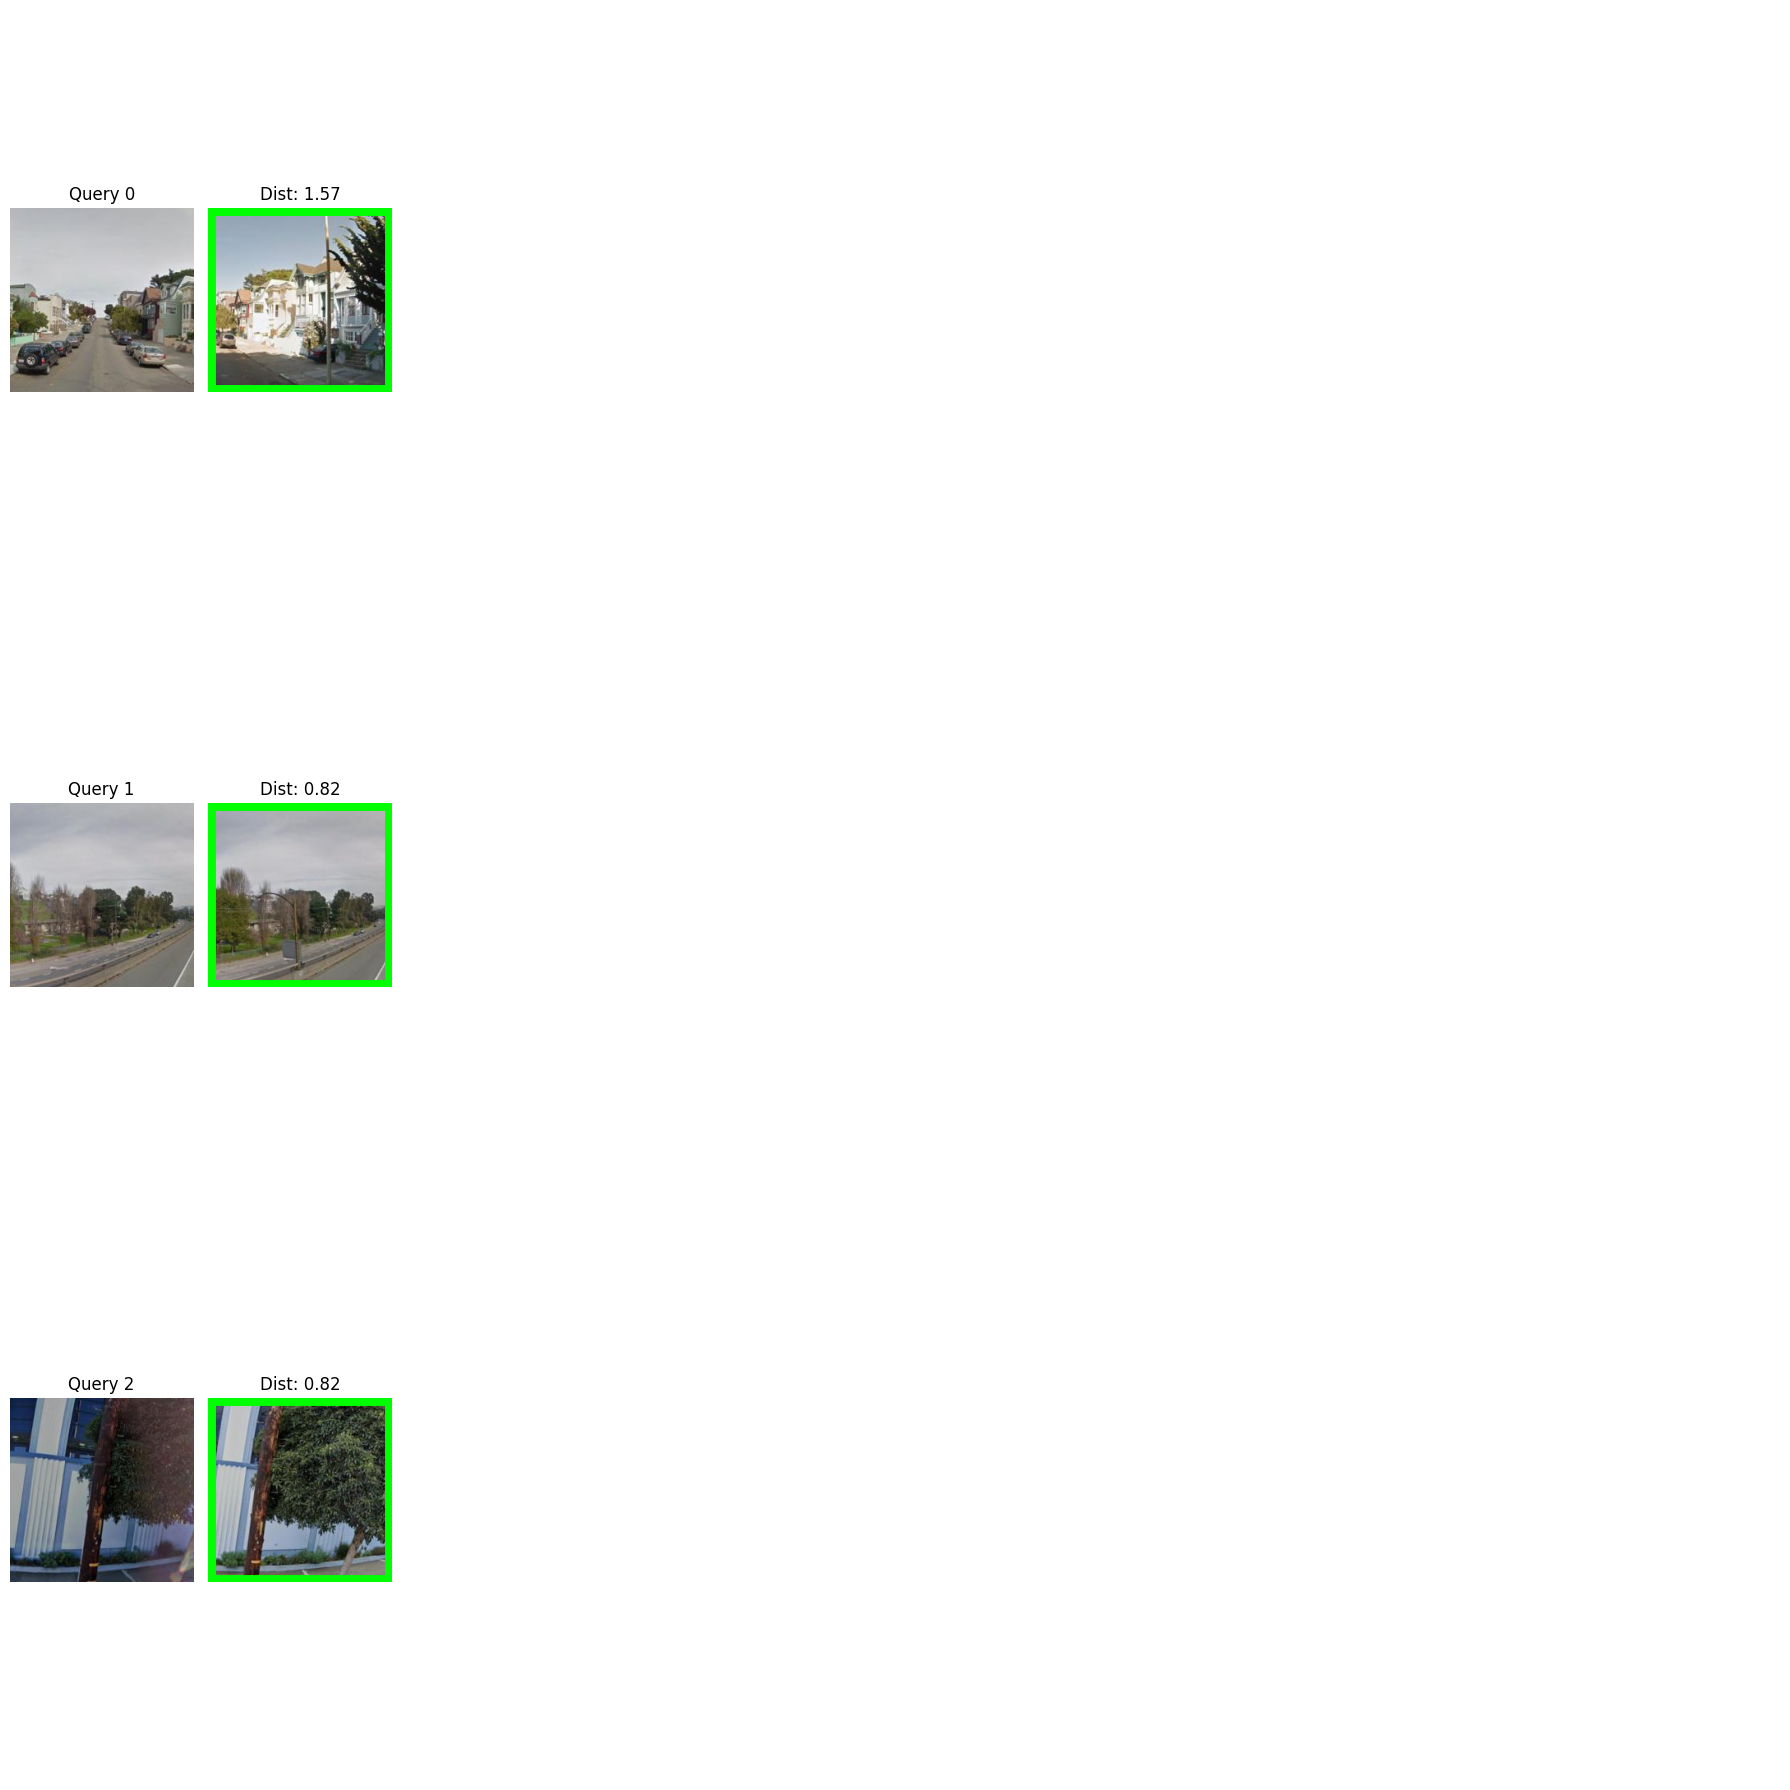

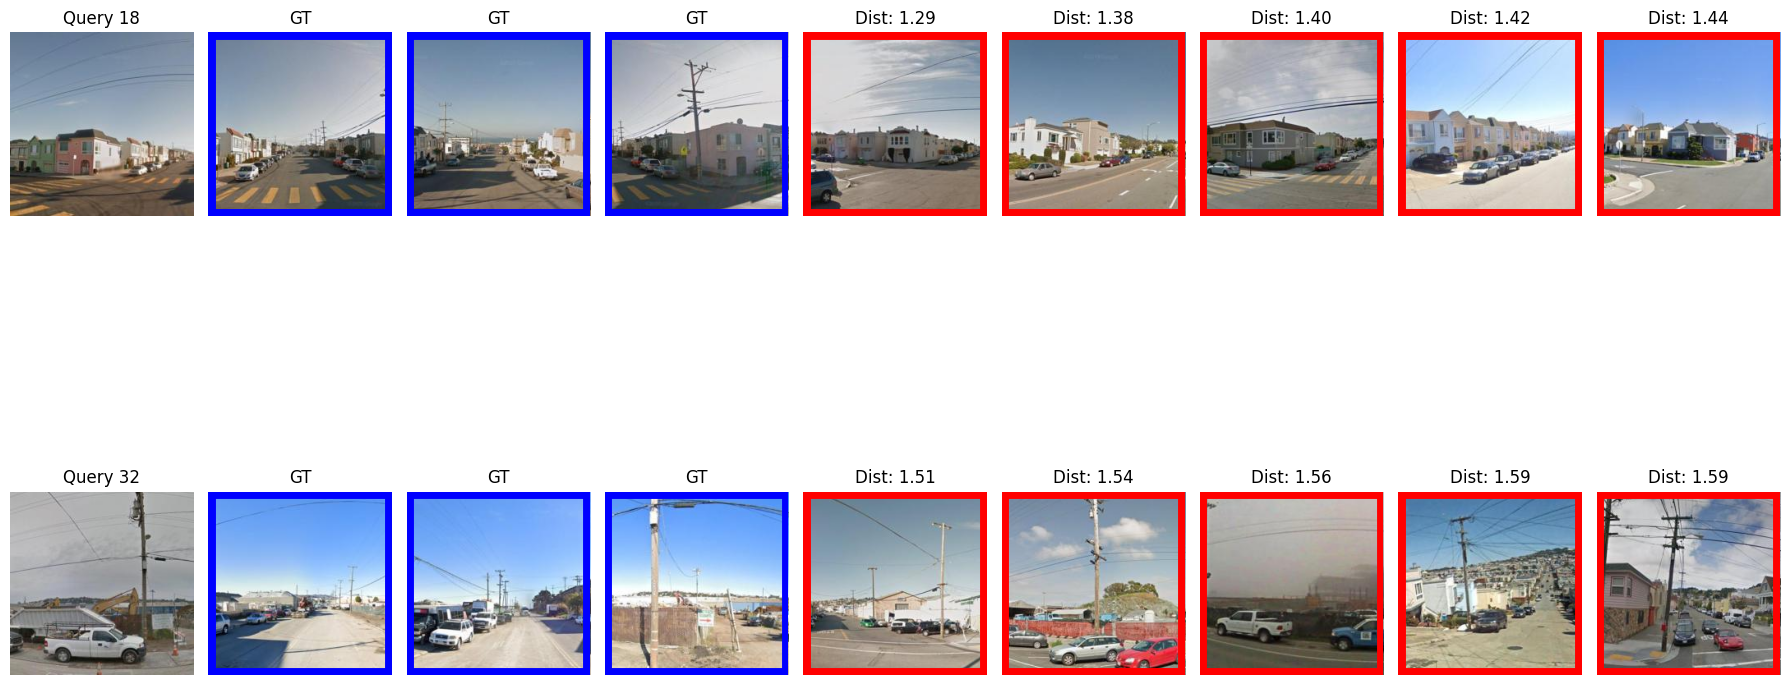

========> DONE!


num queries
315
Evaluating on tokyotest


Calculating descritptors...:   0%|          | 0/328 [00:00<?, ?it/s]



+----------------------------------------------------------+
|                 Performance on tokyotest                 |
+----------+-------+-------+-------+-------+-------+-------+
|    K     |   1   |   5   |   10  |   15  |   20  |   25  |
+----------+-------+-------+-------+-------+-------+-------+
| Recall@K | 64.13 | 72.38 | 77.78 | 81.27 | 82.86 | 84.44 |
+----------+-------+-------+-------+-------+-------+-------+
IMAGES OF tokyotest DATASET


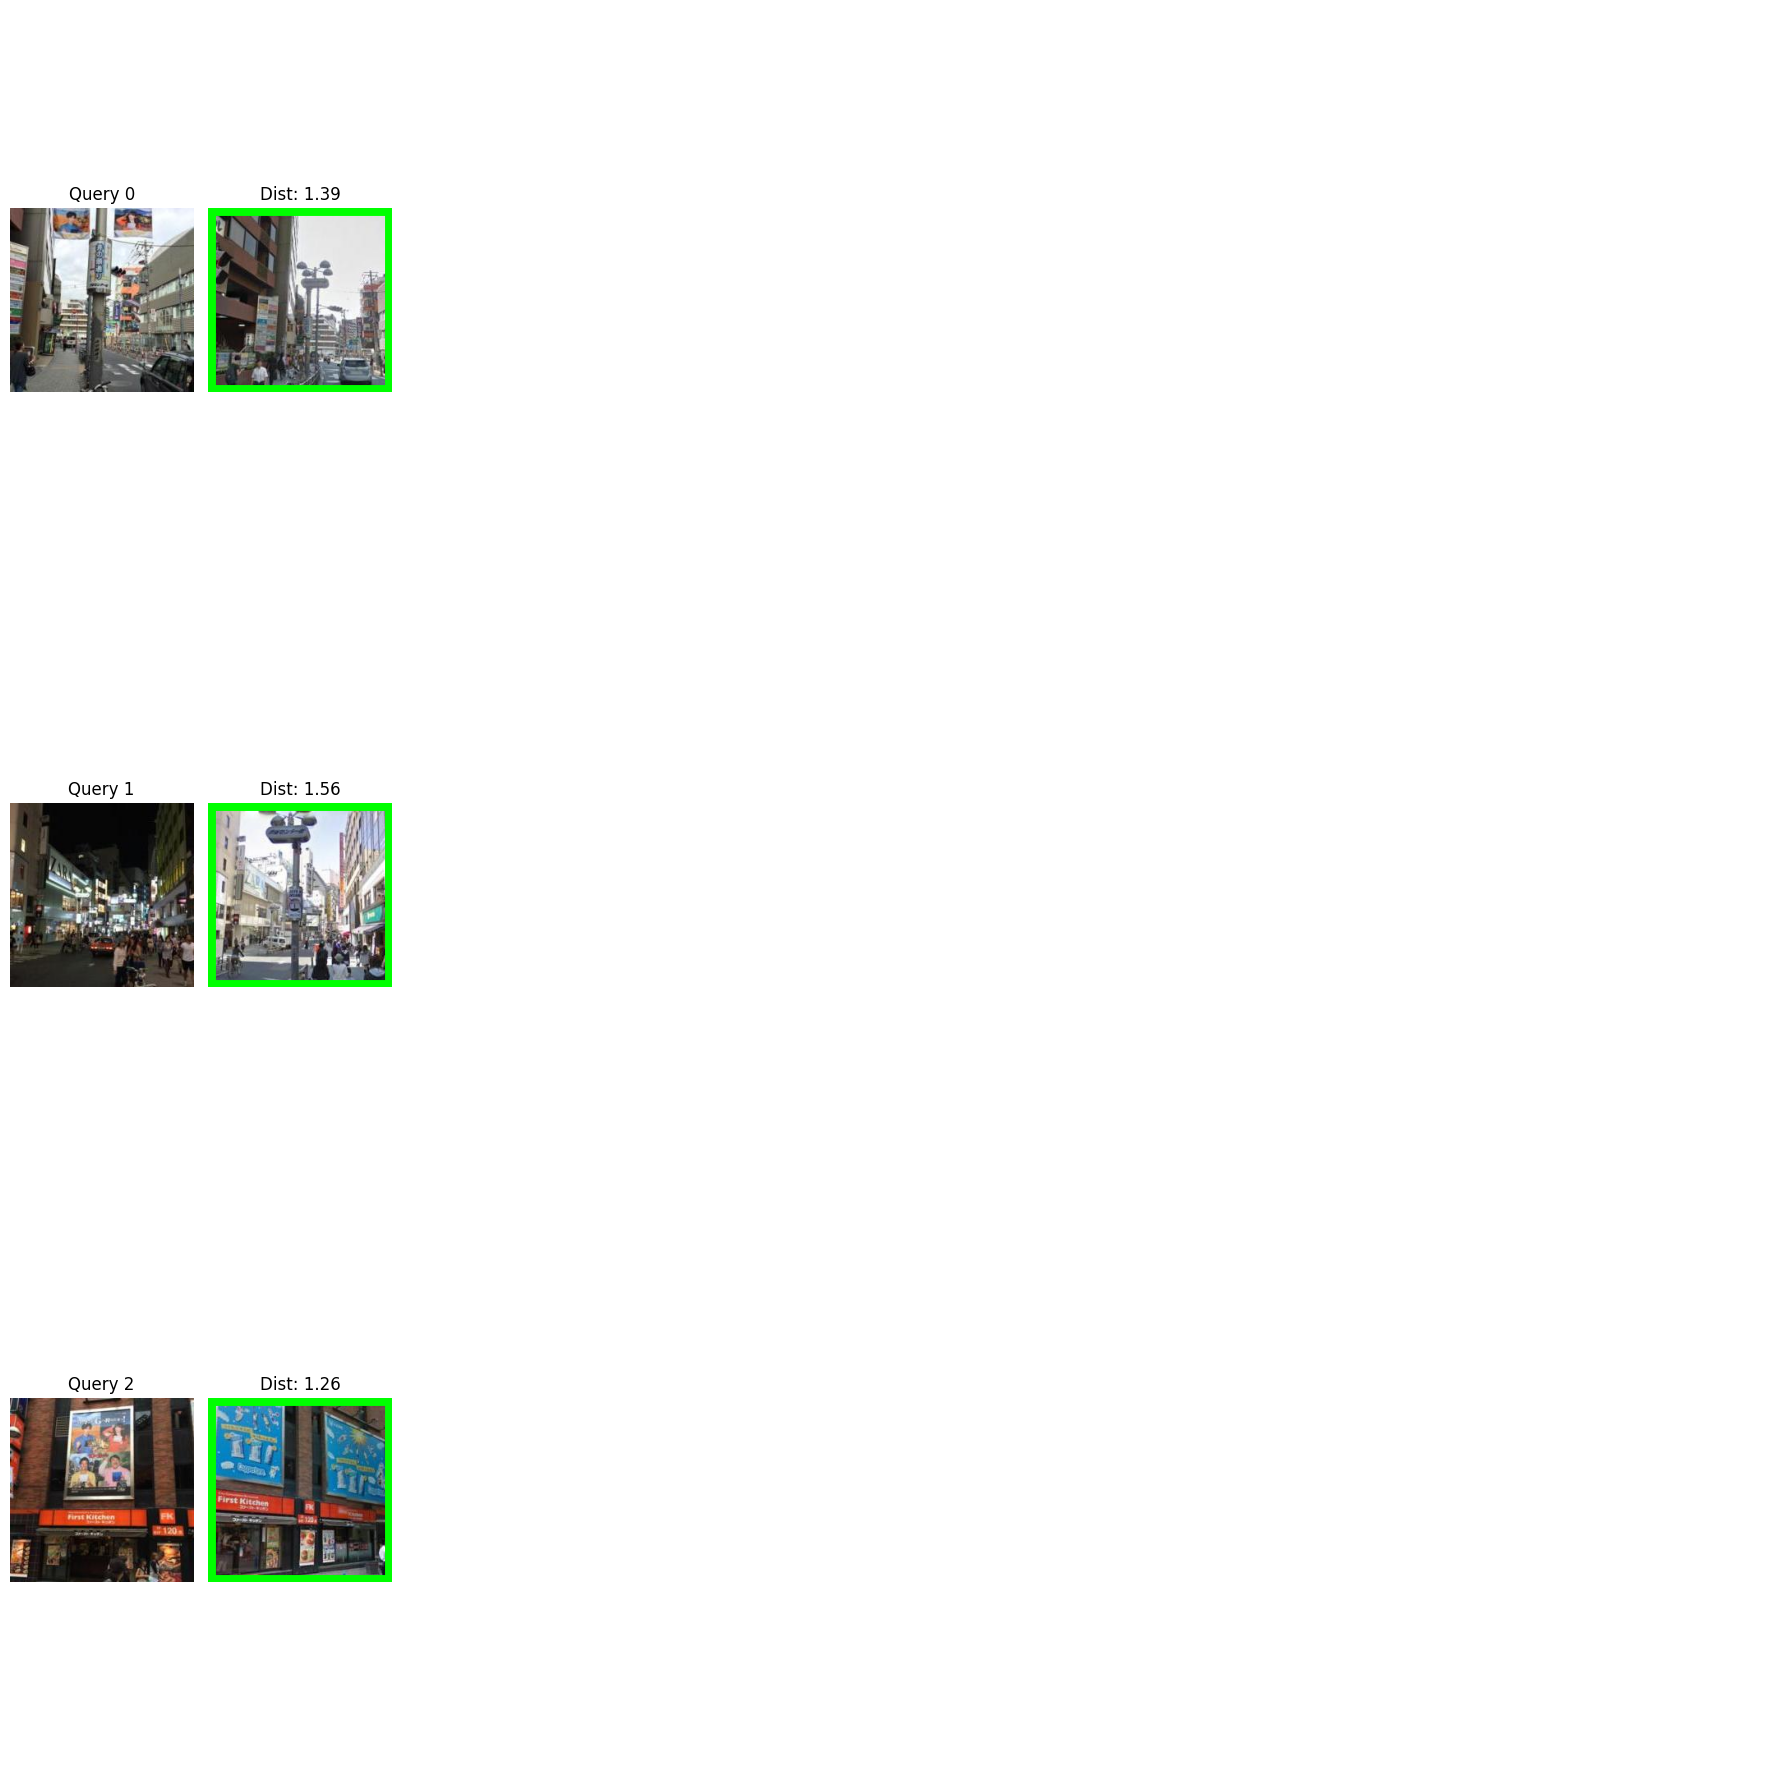

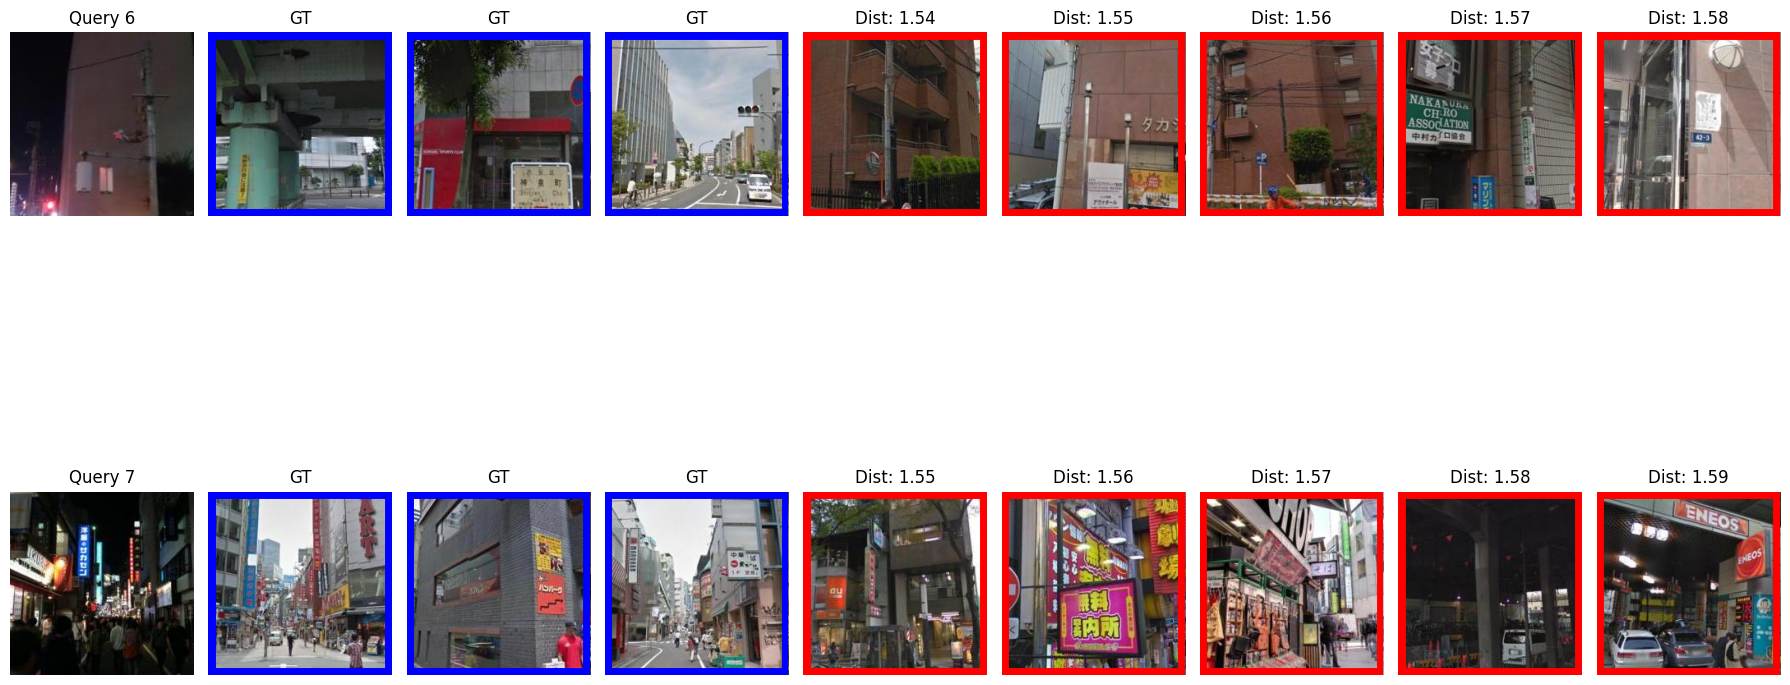

========> DONE!




In [16]:
checkpointList = [
     '/content/drive/My Drive/Colab Notebooks/Latest Version/15 - FINAL TUNING/multisim_mixvpr_epoch=29_loss=0.14000000059604645_sfxsR1=0.8134617805480957_sfxsR5=0.8899036645889282.ckpt'

]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#CAN BE MODIFIED
val_dataset_names = ['sfxstest','sfxsval','tokyotest']
batch_size = 40
correct_map={}
incorrect_map={}
for checkpoint_path in checkpointList:
  print(f'Validating checkpoint: {checkpoint_path}')
  model,device = load_model_from_checkpoint(checkpoint_path,device)
  for val_name in val_dataset_names:
      val_dataset, num_references, num_queries, ground_truth = get_val_dataset(val_name)
      val_loader = DataLoader(val_dataset, num_workers=4, batch_size=batch_size)
      print(f'Evaluating on {val_name}')
      descriptors = get_descriptors(model, val_loader, device)

      #print(f'Descriptor dimension {descriptors.shape[1]}')
      r_list = descriptors[ : num_references].cpu()
      q_list = descriptors[num_references : ].cpu()

      recalls_dict, preds,correct,incorrect = get_validation_recalls(r_list=r_list,
                                                  q_list=q_list,
                                                  k_values=[1, 5, 10, 15, 20, 25],
                                                  gt=ground_truth,
                                                  print_results=True,
                                                  dataset_name=val_name,
                                                  )
      correct_map[val_name]= correct
      incorrect_map[val_name] = incorrect

      if val_name == 'sfxsval':
        query_file = '/content/drive/MyDrive/Datasets/sf_xs/val/val_qImages.npy'
        reference_file = '/content/drive/MyDrive/Datasets/sf_xs/val/val_dbImages.npy'
        ground_truth_file = '/content/drive/MyDrive/Datasets/sf_xs/val/val_gt.npy'
        query_folder_path = '/content/drive/My Drive/Datasets/sf_xs/val/queries/'
        reference_folder_path = '/content/drive/My Drive/Datasets/sf_xs/val/database/'

      if val_name == 'sfxstest':
        query_file = '/content/drive/MyDrive/Datasets/sf_xs/test/test_qImages.npy'
        reference_file = '/content/drive/MyDrive/Datasets/sf_xs/test/test_dbImages.npy'
        ground_truth_file = '/content/drive/MyDrive/Datasets/sf_xs/test/test_gt.npy'
        query_folder_path = '/content/drive/My Drive/Datasets/sf_xs/test/queries/'
        reference_folder_path = '/content/drive/My Drive/Datasets/sf_xs/test/database/'

      if val_name == 'tokyotest':
        query_file = '/content/drive/MyDrive/Datasets/tokyo_xs/test/test_qImages.npy'
        reference_file = '/content/drive/MyDrive/Datasets/tokyo_xs/test/test_dbImages.npy'
        query_folder_path = '/content/drive/My Drive/Datasets/tokyo_xs/test/queries/'
        reference_folder_path = '/content/drive/My Drive/Datasets/tokyo_xs/test/database/'
        ground_truth_file = '/content/drive/MyDrive/Datasets/tokyo_xs/test/test_gt.npy'

      # Lista di tuple con indici (query_index, tensor(reference_index))
      correct_pairs = correct_map[val_name]
      incorrect_pairs = incorrect_map[val_name]

      # Estrai i nomi e le distanze
      correct_reference_pairs = extract_names_and_distances(correct_pairs, query_file, reference_file, ground_truth_file)
      incorrect_reference_pairs = extract_names_and_distances(incorrect_pairs, query_file, reference_file, ground_truth_file)

      # Seleziona solo le prime 3 coppie corrette e le prime 3 coppie incorrette
      correct_reference_pairs = correct_reference_pairs[:3]
      incorrect_reference_pairs = incorrect_reference_pairs[:2]


      print("IMAGES OF "+val_name+ " DATASET")
      # Plot correct pairs and incorrect pairs
      plot_images(correct_reference_pairs, query_folder_path, reference_folder_path, True)
      plot_images(incorrect_reference_pairs, query_folder_path, reference_folder_path, False)
      #Clear maps here
      correct_map.clear()
      incorrect_map.clear()
      del descriptors
      print('========> DONE!\n\n')